# Pre-requisites

1. Install [`python-ace`](https://github.com/ICAMS/python-ace) and [`tensorpotential`](https://github.com/ICAMS/TensorPotential), check more instructions [here](https://pacemaker.readthedocs.io/en/latest/pacemaker/install/) into pyiron conda environment

2. Add following files into `~/pyiron/resources/pacemaker/bin`:

**~/pyiron/resources/pacemaker/bin/run_pacemaker_tf.sh**:
```bash
#!/bin/bash

source $HOME/.bashrc
conda activate PYIRON_AND_PACEMAKER_CONDA_ENVIRONMENT
TF_FORCE_GPU_ALLOW_GROWTH=true pacemaker input.yaml -l log.txt
pace_yaml2yace output_potential.yaml
```

**~/pyiron/resources/pacemaker/bin/run_pacemaker_tf_cpu.sh**:
```bash
#!/bin/bash

source $HOME/.bashrc
conda activate PYIRON_AND_PACEMAKER_CONDA_ENVIRONMENT
CUDA_VISIBLE_DEVICES=-1 pacemaker input.yaml -l log.txt
pace_yaml2yace output_potential.yaml

```

or get it from https://github.com/pyiron/pyiron-resources

# Import and load

In [ ]:
%pylab inline

In [2]:
from pyiron_contrib import Project

In [3]:
pr = Project('fit_project')

In [8]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,2,finished,None,initial,/initial,None,/home/users/lysogy36/PycharmProjects/pyiron2021/pyiron_contrib/workshop_data/unpack/initial/,2022-05-20 07:33:26.696857,None,None,zora@cmti001#1,TrainingContainer,0.4,None,None
1,3,finished,None,offstoichiometry,/offstoichiometry,None,/home/users/lysogy36/PycharmProjects/pyiron2021/pyiron_contrib/workshop_data/unpack/initial/,2022-05-20 07:40:54.302418,None,None,zora@cmti001#1,TrainingContainer,0.4,None,None


# Loading training containers

In [4]:
training_container_1 = pr['initial/initial']

In [5]:
training_container_2 = pr['initial/offstoichiometry']

# Create PacemakerJob

In [9]:
job = pr.create_job(pr.job_type.PacemakerJob, "pacemaker_job")

In [10]:
job.add_training_data(training_container_1)

In [11]:
job.add_training_data(training_container_2)

In [12]:
# set cutoff
job.cutoff=7.0

In [37]:
# set number of iterations
job.input["fit"]["maxiter"]=1000

In [38]:
job.input

,Parameter,Value,Comment
0,cutoff,7.0,
1,metadata,"{'comment': 'pyiron-generated fitting job', 'pyiron_job_id': '4'}",
2,data,{'filename': '/home/users/lysogy36/PycharmProjects/pyiron2021/pyiron_contrib/workshop_data/unpack/pacemaker_job_hdf5/pacemaker_job/df_fit.pckl.gzip'},
3,potential,"{'elements': ['Al', 'Li'], 'bonds': {'ALL': {'radbase': 'SBessel', 'rcut': 7.0, 'dcut': 0.01, 'radparameters': [5.25]}}, 'embeddings': {'ALL': {'fs_parameters': [1, 1, 1, 0.5], 'ndensity': 2, 'npo...",
4,fit,"{'loss': {'L1_coeffs': 1e-08, 'L2_coeffs': 1e-08, 'kappa': 0.3, 'w0_rad': 0, 'w1_rad': 0, 'w2_rad': 0}, 'maxiter': 1000, 'optimizer': 'BFGS', 'fit_cycles': 1}",
5,backend,"{'batch_size': 100, 'display_step': 50, 'evaluator': 'tensorpot'}",


# Run fit

In [17]:
job.run()

Set automatically determined list of elements: ['Al', 'Li']
The job pacemaker_job was saved and received the ID: 4


In [46]:
job.collect_output()

# Analyse fit

plot loss function

[]

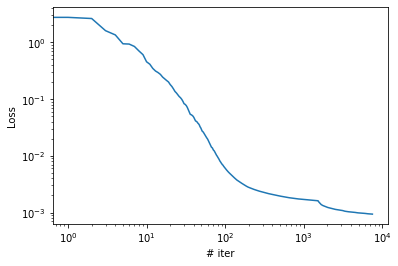

In [48]:
plt.plot(job["output/log/loss"])
plt.xlabel("# iter")
plt.ylabel("Loss")
plt.loglog()

plot energy per atom RMSE

[]

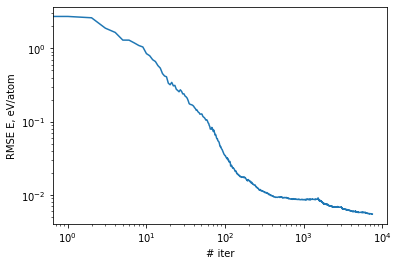

In [50]:
plt.plot(job["output/log/rmse_epa"])
plt.xlabel("# iter")
plt.ylabel("RMSE E, eV/atom")
plt.loglog()

plot force component RMSE

[]

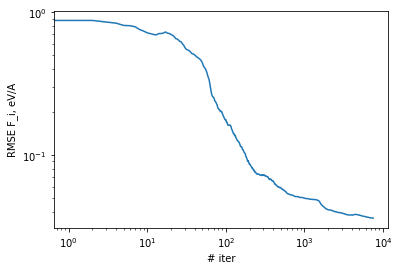

In [51]:
plt.plot(job["output/log/rmse_f_comp"])
plt.xlabel("# iter")
plt.ylabel("RMSE F_i, eV/A")
plt.loglog()

load DataFrame with predictions

In [52]:
pred_df = job.predicted_data

In [53]:
pred_df["energy_pred_per_atom"] = pred_df["energy_pred"]/pred_df["NUMBER_OF_ATOMS"]

Text(0, 0.5, 'ACE E, eV/atom')

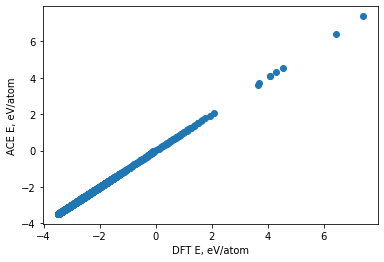

In [54]:
plt.scatter(pred_df["energy_corrected_per_atom"], pred_df["energy_pred_per_atom"])
plt.xlabel("DFT E, eV/atom")
plt.ylabel("ACE E, eV/atom")

Text(0, 0.5, 'ACE F_i, eV/A')

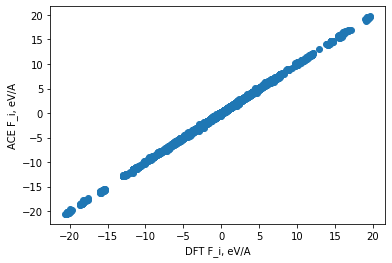

In [55]:
plt.scatter(np.vstack(pred_df["forces"]),  np.vstack(pred_df["forces_pred"]))
plt.xlabel("DFT F_i, eV/A")
plt.ylabel("ACE F_i, eV/A")

Check more in `job.working_directory`/report folder

In [43]:
! ls {job.working_directory}/report

train_E-dE-dist.png  train_EF-pairplots.png  train_Fi-dFi-dist.png
train_E-dE-nn.png    train_F-dF-dist.png


# Get LAMMPS potential 

In [34]:
lammps_potential = job.get_lammps_potential()
lammps_potential

,Config,Filename,Model,Name,Species
0,"[pair_style pace\n, pair_coeff * * /home/users/lysogy36/PycharmProjects/pyiron2021/pyiron_contrib/workshop_data/unpack/pacemaker_job_hdf5/pacemaker_job/output_potential.yace Al Li\n]",,ACE,pacemaker_job,"[Al, Li]"
